In [34]:
import sys
sys.path.append('/mnt/data/Dropbox/GRIMSEL_SOURCE/grimsel')



In [35]:
from grimsel.core.io import IO
import numpy as np
import pandas as pd
import grimsel.core.model_loop as model_loop
from grimsel.core.model_base import ModelBase as MB
from grimsel import logger
logger.setLevel(0)

In [36]:
df_def_node = pd.DataFrame({'nd': ['Node1'], 
                            'nd_id':[0], 
                            'price_co2': [10],
                            'nd_weight': [1]})
dict_nd = df_def_node.set_index('nd').nd_id.to_dict()
display(df_def_node)

,nd,nd_id,price_co2,nd_weight
0,Node1,0,10,1


In [37]:
df_def_fuel = pd.DataFrame({'fl_id': range(3),
                            'fl': ['natural_gas', 'hard_coal', 'solar'], 
                            'co2_int': [0.20, 0.35, 0]})
dict_fl = df_def_fuel.set_index('fl').fl_id.to_dict()
display(df_def_fuel)

,fl_id,fl,co2_int
0,0,natural_gas,0.20
1,1,hard_coal,0.35
2,2,solar,0.00


In [38]:
df_def_encar = pd.DataFrame({'ca_id': [0],
                             'ca': ['EL']})
dict_ca = df_def_encar.set_index('ca').ca_id.to_dict()
display(df_def_encar)

,ca_id,ca
0,0,EL


In [39]:
df_def_pp_type = pd.DataFrame({'pt_id': range(3), 'pt': ['GAS_LIN', 'SOLAR', 'HCO_ELC']})
dict_pt = df_def_pp_type.set_index('pt').pt_id.to_dict()
display(df_def_pp_type)

,pt_id,pt
0,0,GAS_LIN
1,1,SOLAR
2,2,HCO_ELC


In [40]:
df_def_plant = pd.DataFrame({'pp': ['ND1_GAS_LIN', 'ND1_GAS_NEW', 'ND1_SOLAR', 'ND1_HCO_ELC'],
                             'pp_id': range(4),
                             'pt_id': ['GAS_LIN', 'GAS_LIN', 'SOLAR', 'HCO_ELC'],
                             'nd_id': ['Node1'] * 4,
                             'fl_id': ['natural_gas', 'natural_gas', 'solar', 'hard_coal'],
                             'set_def_pr': [0, 0, 1, 0],
                             'set_def_pp': [1, 1, 0, 1],
                             'set_def_lin': [1, 0, 0, 0],
                             'set_def_add': [0, 1, 1, 0],
                            })
# translate columns to id using the previously defined def tables
df_def_plant = df_def_plant.assign(pt_id=df_def_plant.pt_id.replace(dict_pt),
                                   nd_id=df_def_plant.nd_id.replace(dict_nd),
                                   fl_id=df_def_plant.fl_id.replace(dict_fl))
dict_pp = df_def_plant.set_index('pp').pp_id.to_dict()

display(df_def_plant)

,pp,pp_id,pt_id,nd_id,fl_id,set_def_pr,set_def_pp,set_def_lin,set_def_add
0,ND1_GAS_LIN,0,0,0,0,0,1,1,0
1,ND1_GAS_NEW,1,0,0,0,0,1,0,1
2,ND1_SOLAR,2,1,0,2,1,0,0,1
3,ND1_HCO_ELC,3,2,0,1,0,1,0,0


In [41]:
df_def_profile = pd.DataFrame({'pf_id': range(2),
                               'pf': ['SUPPLY_SOLAR', 'DMND_NODE1']})
dict_pf = df_def_profile.set_index('pf').pf_id.to_dict()
display(df_def_profile)

,pf_id,pf
0,0,SUPPLY_SOLAR
1,1,DMND_NODE1


In [44]:
eff_gas_min = 0.4
eff_gas_max = 0.6
cap_gas = 4000.
f0_gas = 1/eff_gas_min
f1_gas = 1/cap_gas * (f0_gas - 1/eff_gas_max)


dr, lt = 0.06, 20 # assumed discount rate 6% and life time
fact_ann = ((1+dr)**lt * dr) / ((1+dr)**lt - 1)

fc_cp_gas = 800000  # assumed capital cost nenw gas plants (EUR/MW)
fc_cp_gas_ann = fact_ann * fc_cp_gas

fc_cp_solar = 1500000  # assumed capital cost solar power (EUR/MW)
fc_cp_solar_ann = fact_ann * fc_cp_solar

df_plant_encar = pd.DataFrame({'pp_id': ['ND1_GAS_LIN', 'ND1_GAS_NEW', 'ND1_SOLAR', 'ND1_HCO_ELC'],
                               'ca_id': ['EL'] * 4,
                               'supply_pf_id': [None, None, 'SUPPLY_SOLAR', None],
                               'pp_eff': [None, eff_gas_max, None, 0.4],
                               'factor_lin_0': [f0_gas, None, None, None],
                               'factor_lin_1': [f1_gas, None, None, None],
                               'cap_pwr_leg': [0, 0, 0, 5000],
                               'fc_cp_ann': [None, fc_cp_gas_ann, fc_cp_solar_ann, None],
                              })

df_plant_encar = df_plant_encar.assign(supply_pf_id=df_plant_encar.supply_pf_id.replace(dict_pf),
                                       pp_id=df_plant_encar.pp_id.replace(dict_pp),
                                       ca_id=df_plant_encar.ca_id.replace(dict_ca))
display(df_plant_encar)

,pp_id,ca_id,supply_pf_id,pp_eff,factor_lin_0,factor_lin_1,cap_pwr_leg,fc_cp_ann
0,0,0,None,NaN,2.5,0.000208,0,NaN
1,1,0,None,0.6,NaN,NaN,0,69747.645581
2,2,0,0,NaN,NaN,NaN,0,130776.835465
3,3,0,None,0.4,NaN,NaN,5000,NaN


In [45]:
fc_cp_solar_ann

130776.83546527711

In [46]:
df_node_encar = pd.DataFrame({'nd_id': ['Node1'], 'ca_id': ['EL'],
                              'dmnd_pf_id': ['DMND_NODE1']
                              })
df_node_encar = df_node_encar.assign(nd_id=df_node_encar.nd_id.replace(dict_nd),
                                     ca_id=df_node_encar.ca_id.replace(dict_ca),
                                     dmnd_pf_id=df_node_encar.dmnd_pf_id.replace(dict_pf))
df_node_encar

,nd_id,ca_id,dmnd_pf_id
0,0,0,1


In [47]:
df_fuel_node_encar = pd.DataFrame({'fl_id': ['natural_gas', 'hard_coal'],
                                   'nd_id': ['Node1'] * 2,
                                   'ca_id': ['EL'] * 2,
                                   'vc_fl': [40, 10],
                                  })
df_fuel_node_encar = df_fuel_node_encar.assign(fl_id=df_fuel_node_encar.fl_id.replace(dict_fl),
                                       nd_id=df_fuel_node_encar.nd_id.replace(dict_nd),
                                       ca_id=df_fuel_node_encar.ca_id.replace(dict_ca))
df_fuel_node_encar

,fl_id,nd_id,ca_id,vc_fl
0,0,0,0,40
1,1,0,0,10


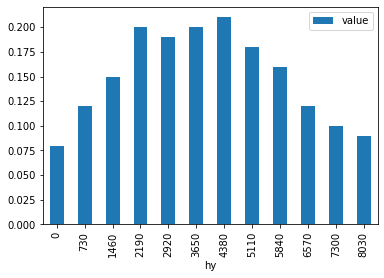

In [48]:
prf = [0.08, 0.12, 0.15, 0.20, 0.19, 0.20, 
       0.21, 0.18, 0.16, 0.12, 0.10, 0.09]
df_profsupply = pd.DataFrame({'supply_pf_id': [dict_pf['SUPPLY_SOLAR']] * len(prf),
                              'hy': range(0, 8760, 730), 'value': prf})

_ = df_profsupply.set_index('hy')[['value']].plot.bar()

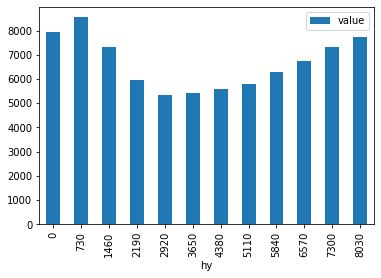

In [49]:
prf = [7951.7, 8543.8, 7302.0, 5938.3, 5323.8, 5411.6, 
       5582.0, 5776.5, 6304.9, 6736.7, 7327.8, 7720.7]

df_profdmnd = pd.DataFrame({'dmnd_pf_id': [dict_pf['DMND_NODE1']] * len(prf),
                            'hy':  range(0, 8760, 730), 'value': prf})

_ = df_profdmnd.set_index('hy')[['value']].plot.bar()

In [50]:
import os
try: os.mkdir('introductory_example_files')
except: pass
for dftb, tbname in [(df_def_node, 'def_node'),
                   (df_def_plant, 'def_plant'),
                   (df_def_fuel, 'def_fuel'),
                   (df_def_encar, 'def_encar'),
                   (df_node_encar, 'node_encar'),
                   (df_def_pp_type, 'def_pp_type'),
                   (df_plant_encar, 'plant_encar'),
                   (df_def_profile, 'def_profile'),
                   (df_fuel_node_encar, 'fuel_node_encar'),
                   (df_profsupply, 'profsupply'),
                   (df_profdmnd, 'profdmnd')]:
    dftb.to_csv('introductory_example_files/{}.csv'.format(tbname), index=False)

In [51]:
from grimsel.core.model_base import ModelBase
mkwargs = {}

ModelBase(**mkwargs)


In [17]:
mkwargs = {'nhours': (730, 730)}
iokwargs = {'data_path': os.path.abspath('introductory_example_files/'),
            'output_target': 'fastparquet',
            'autocomplete_curtailment': True,
            'cl_out': 'introductory_example_files/output',  # output collection (here: path for parquet files)
            'dev_mode': True, # skips confirmation prompt prior to overwriting existing output files
           }

In [18]:
nsteps = [('swco', 5, np.linspace),  # CO2 emission price
          ('swnewgas', 2, np.arange),  # allow installation of new gas plants yes/no
         ]

In [19]:
dict_swnewgas = {0: 'default', 1: 'exclude_gas'}

In [20]:
logger.setLevel('ERROR')
ml = model_loop.ModelLoop(nsteps=nsteps, mkwargs=mkwargs, iokwargs=iokwargs)

In [21]:
ml.df_def_run

,run_id,swco_id,swnewgas_id,swco,swnewgas,swco_vl,swnewgas_vl
0,0,0.0,0.0,0.00,0.0,NaN,NaN
1,1,1.0,0.0,0.25,0.0,NaN,NaN
2,2,2.0,0.0,0.50,0.0,NaN,NaN
3,3,3.0,0.0,0.75,0.0,NaN,NaN
4,4,4.0,0.0,1.00,0.0,NaN,NaN
5,5,0.0,1.0,0.00,1.0,NaN,NaN
6,6,1.0,1.0,0.25,1.0,NaN,NaN
7,7,2.0,1.0,0.50,1.0,NaN,NaN
8,8,3.0,1.0,0.75,1.0,NaN,NaN
9,9,4.0,1.0,1.00,1.0,NaN,NaN


In [22]:
mask_remove = ((ml.df_def_run.swnewgas_id == {v: k for k, v in dict_swnewgas.items()}['exclude_gas'])
               & (ml.df_def_run.swco_id % 2 != 0))
ml.df_def_run = ml.df_def_run.loc[~mask_remove]
ml.df_def_run

,run_id,swco_id,swnewgas_id,swco,swnewgas,swco_vl,swnewgas_vl
0,0,0.0,0.0,0.00,0.0,NaN,NaN
1,1,1.0,0.0,0.25,0.0,NaN,NaN
2,2,2.0,0.0,0.50,0.0,NaN,NaN
3,3,3.0,0.0,0.75,0.0,NaN,NaN
4,4,4.0,0.0,1.00,0.0,NaN,NaN
5,5,0.0,1.0,0.00,1.0,NaN,NaN
6,6,2.0,1.0,0.50,1.0,NaN,NaN
7,7,4.0,1.0,1.00,1.0,NaN,NaN


In [23]:
ml.m.df_def_plant

,pp,pp_id,pt_id,nd_id,fl_id,set_def_pr,set_def_pp,set_def_lin,set_def_add,set_def_dmd,set_def_curt
0,ND1_GAS_LIN,0,0,0,0,0,1,1,0,0.0,0.0
1,ND1_GAS_NEW,1,0,0,0,0,1,0,1,0.0,0.0
2,ND1_SOLAR,2,1,0,2,1,0,0,1,0.0,0.0
3,ND1_HCO_ELC,3,2,0,1,0,1,0,0,0.0,0.0
0,Node1_DMND_FLEX,4,4,0,3,0,0,0,0,0.0,1.0
1,Node1_DMND,5,5,0,4,0,0,0,0,1.0,0.0


In [52]:
class ModelLoopModifier():

    def __init__(self, ml):
        self.ml = ml

    def change_swco(self, max_co2_price):

        # steps from 0 to 1 (column ``swco`` in the df_def_run)
        new_co2_price = self.ml.dct_step['swco'] * max_co2_price

        for key in ml.m.price_co2:
            self.ml.m.price_co2[key] = new_co2_price

        self.ml.dct_vl['swco_vl'] = f'{int(new_co2_price):04d}EUR/tCO2'

        
    def change_gas(self, dict_swnewgas):

        slct_swnewgas = dict_swnewgas[self.ml.dct_step['swnewgas']]

        # get the power plant id id of new gas plants
        pp_id_gas_new = self.ml.m.mps.dict_pp_id['ND1_GAS_NEW']

        if slct_swnewgas == 'exclude_gas':
            # fix investment variables at zero
            for key in self.ml.m.cap_pwr_new:
                if key[0] == pp_id_gas_new:  # the variable is indexed (pp_id, ca_id)
                    self.ml.m.cap_pwr_new[key].value = 0
                    self.ml.m.cap_pwr_new[key].fix()

        self.ml.dct_vl['swnewgas_vl'] = slct_swnewgas

In [58]:
# generate a ModelLoopModifier instance
mlm = ModelLoopModifier(ml)

def run_model(run_id):

    # advance the model loop
    ml.select_run(run_id)

    # reset all model variables and parameters so we start from the
    # same conditions on every loop
    ml.m.reset_all_parameters()
    ml.m.unfix_all_vars()

    # use the ModelLoopModifiers to change the model parameters and variables
    mlm.change_swco(max_co2_price=200)
    mlm.change_gas(dict_swnewgas)

    ############### RUN MODEL ###############
    ml.perform_model_run()

In [62]:
from grimsel.auxiliary.multiproc import run_parallel, run_sequential
from glob import glob

run_parallel(ml, func=run_model, nproc=10, adjust_logger_levels=True)


Solver script file=/tmp/tmphcd1ykej.cplex.script
Solver script file=/tmp/tmplt0h4uzr.cplex.script
Solver script file=/tmp/tmpyjn9vmux.cplex.script
Solver script file=/tmp/tmp3nyr47uo.cplex.script
Solver log file: '/tmp/tmpwrxd9xmv.cplex.log'
Solver log file: '/tmp/tmp_ndycne5.cplex.log'
Solver log file: '/tmp/tmpeti0ofif.cplex.log'
Solver log file: '/tmp/tmp_nqdr5v1.cplex.log'
Solver script file=/tmp/tmp1ju__ibs.cplex.script
Solver solution file: '/tmp/tmpk1dur59q.cplex.sol'
Solver solution file: '/tmp/tmp4iwh4_rx.cplex.sol'
Solver solution file: '/tmp/tmp8xsu7vd4.cplex.sol'
Solver log file: '/tmp/tmp0rmcug2k.cplex.log'
Solver solution file: '/tmp/tmpzili5a4q.cplex.sol'
Solver solution file: '/tmp/tmpy0h91d2q.cplex.sol'
Solver script file=/tmp/tmptolmq9pl.cplex.script
Solver problem files: ('/tmp/tmpkjz0o0fh.pyomo.lp',)
Solver problem files: ('/tmp/tmpbry7jorl.pyomo.lp',)
Solver problem files: ('/tmp/tmptc6kcgqe.pyomo.lp',)
Solver problem files: ('/tmp/tmprko9u04m.pyomo.lp',)
Solver sc